In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('./temperature.csv')

df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [3]:
def parse_date(row):
    s = f"{row['year']}-{row['month']}-{row['day']}"
    return datetime.strptime(s, "%Y-%m-%d")

In [4]:
df['Date'] = df.apply(parse_date, axis=1)

In [5]:
auckland = df[  df['City'] == 'Auckland'  ].copy().dropna()
stockholm = df[  df['City'] == 'Stockholm'  ].copy().dropna()

In [6]:
auckland = auckland[ ['Date', 'AverageTemperatureFahr'] ].copy()
stockholm = stockholm[ ['Date', 'AverageTemperatureFahr'] ].copy()

In [7]:
auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']

auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [8]:
stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']

stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [9]:
joined = auckland.join(stockholm, how='outer')


In [10]:
joined.shape

(3155, 2)

In [11]:
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

In [12]:
joined_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [13]:
joined_part.interpolate(inplace=True)

In [14]:
joined_part.isna().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

<AxesSubplot: xlabel='Date'>

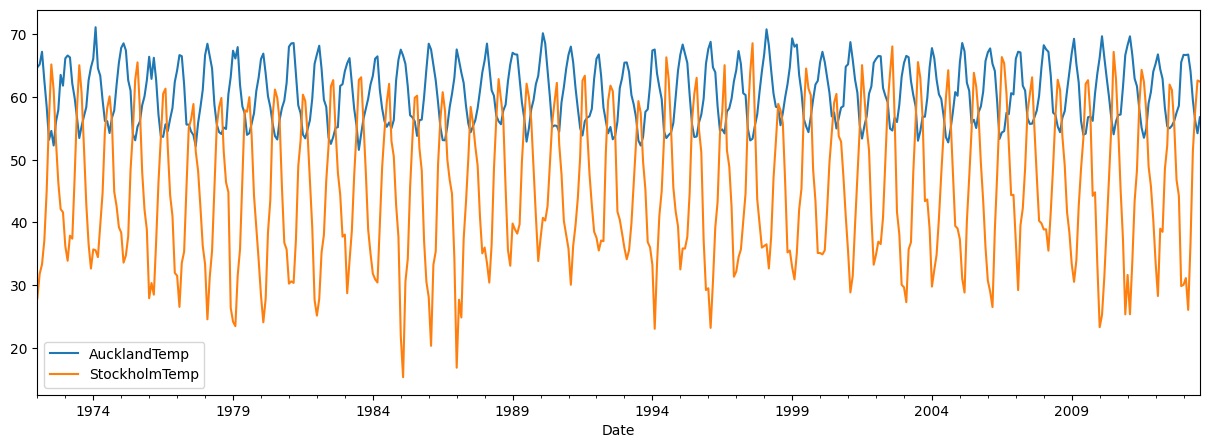

In [15]:
joined_part.plot(figsize=(15, 5))

In [16]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [17]:
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform( train[['AucklandTemp']] )
# what's the difference between .fit_transform() and .transform()
test['ScaledAuckland'] = scaler_auckland.transform( test[['AucklandTemp']] )

In [18]:
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform( train[['StockholmTemp']] )
test['ScaledStockholm'] = scaler_stockholm.transform(test[['StockholmTemp']])

In [19]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [20]:
# Put them back in original df
joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']

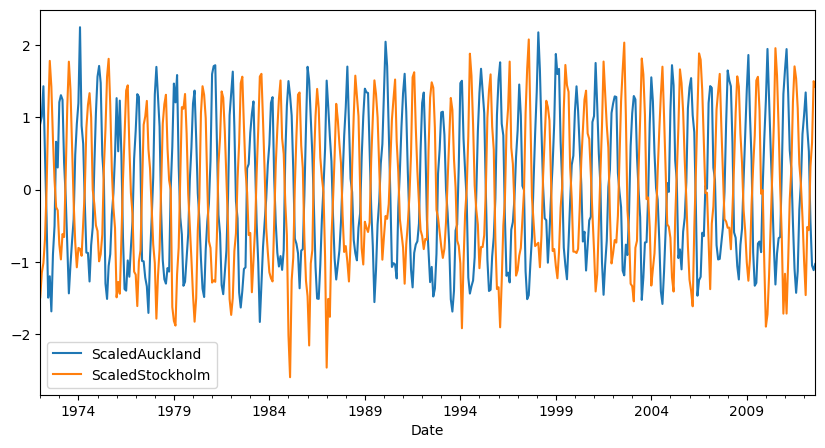

In [21]:
cols = ['ScaledAuckland', 'ScaledStockholm']
train[cols].plot(figsize=(10, 5));

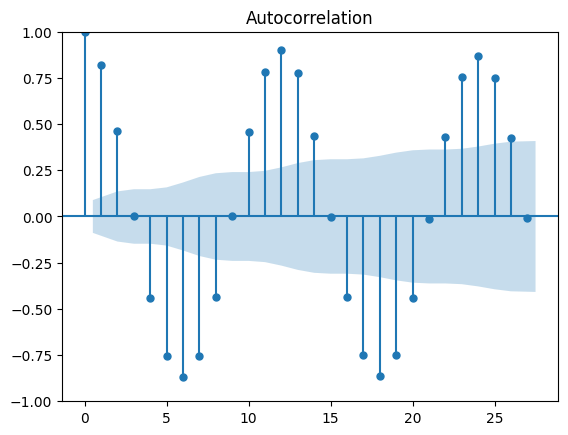

In [22]:
plot_acf(train['ScaledAuckland']);

/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


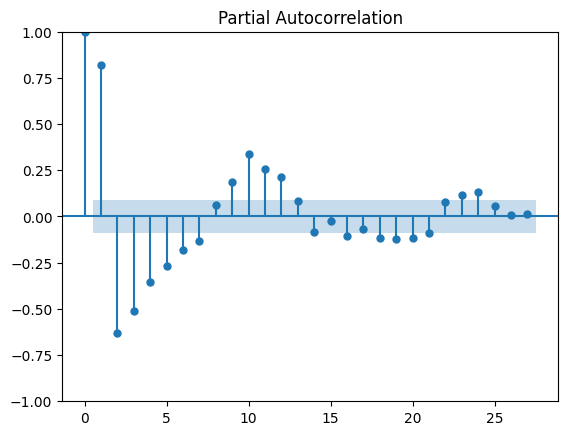

In [23]:
plot_pacf(train['ScaledAuckland']);

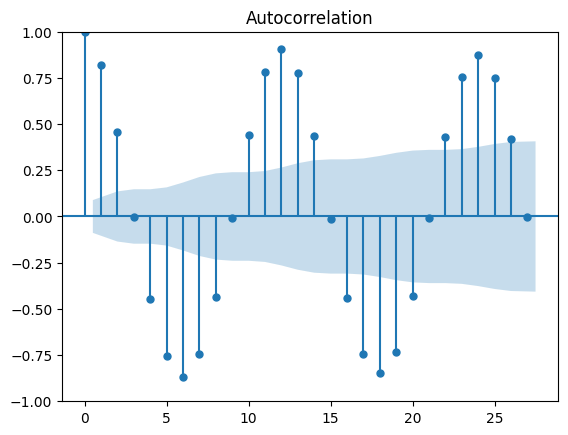

In [24]:
plot_acf(train['ScaledStockholm']);

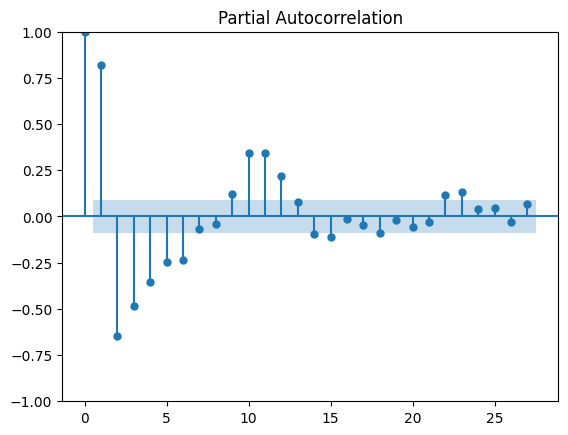

In [25]:
plot_pacf(train['ScaledStockholm']);

In [26]:
t0 = datetime.now()
model = VARMAX(train[cols], order=(10, 10))
res = model.fit(maxiter=100)
print(f"Duation: {datetime.now() - t0}")

/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           85     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88166D-01    |proj g|=  4.98695D-01


 This problem is unconstrained.



At iterate    5    f=  2.74661D-01    |proj g|=  1.76113D-01

At iterate   10    f=  2.57041D-01    |proj g|=  1.21188D-01

At iterate   15    f=  2.43906D-01    |proj g|=  1.86507D-01

At iterate   20    f=  2.28385D-01    |proj g|=  1.44936D-01

At iterate   25    f=  2.16511D-01    |proj g|=  4.70663D-02

At iterate   30    f=  2.12106D-01    |proj g|=  7.70725D-02

At iterate   35    f=  2.06769D-01    |proj g|=  1.98423D-01

At iterate   40    f=  2.05101D-01    |proj g|=  2.67206D-01

At iterate   45    f=  2.03226D-01    |proj g|=  1.50049D-01

At iterate   50    f=  2.01828D-01    |proj g|=  6.03755D-02

At iterate   55    f=  1.99313D-01    |proj g|=  6.36275D-02

At iterate   60    f=  1.96693D-01    |proj g|=  1.60848D-01

At iterate   65    f=  1.93116D-01    |proj g|=  7.89597D-02

At iterate   70    f=  1.91193D-01    |proj g|=  5.95336D-01

At iterate   75    f=  1.88935D-01    |proj g|=  2.38142D-01

At iterate   80    f=  1.85149D-01    |proj g|=  5.79147D-01

At iter

/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duation: 0:02:29.131962


In [27]:
fcast = res.get_forecast(Ntest)

In [28]:
res.fittedvalues['ScaledAuckland']

Date
1972-01-01   -0.007642
1972-02-01    0.830041
1972-03-01    0.717671
1972-04-01    0.818393
1972-05-01   -0.085595
                ...   
2012-04-01    0.516752
2012-05-01   -0.288105
2012-06-01   -1.054508
2012-07-01   -1.339721
2012-08-01   -1.072742
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

In [29]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast.predicted_mean['ScaledAuckland']

<AxesSubplot: xlabel='Date'>

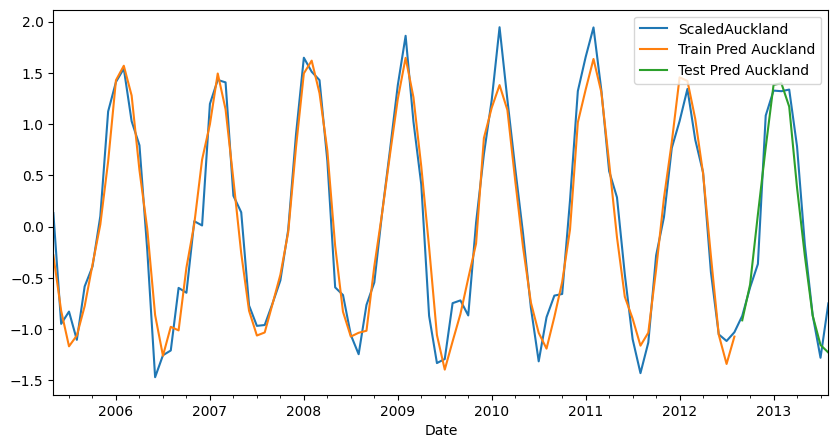

In [30]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(10, 5))

In [31]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast.predicted_mean['ScaledStockholm']

<AxesSubplot: xlabel='Date'>

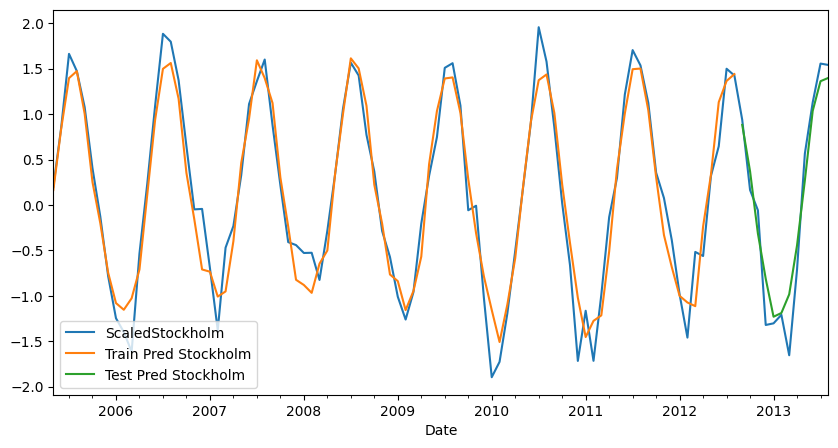

In [32]:
plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(10, 5))

In [33]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
print(f"Auckland Train R^2: {r2_score(y_true, y_pred)}")

Auckland Train R^2: 0.9293612695545115


In [34]:
y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print(f"Auckland Test R^2: {r2_score(y_true, y_pred)}")

Auckland Test R^2: 0.929780910550263


In [35]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print(f"Stockholm Train R^2: {r2_score(y_true, y_pred)}")

Stockholm Train R^2: 0.9247491030429719


In [36]:
y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print(f"Stockholm Test R^2: {r2_score(y_true, y_pred)}")

Stockholm Test R^2: 0.9320120699715536


VAR

In [37]:
model = VAR(train[cols])

In [38]:
lag_order_results = model.select_order(maxlags=15)
lag_order_results

In [39]:
lag_order_results.selected_orders

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

In [40]:
results = model.fit(maxlags=15, ic='aic')

In [41]:
lag_order = results.k_ar

In [42]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)



In [43]:
fcast

array([[-0.86491205,  0.9126215 ],
       [-0.46098815,  0.41187248],
       [ 0.06315052, -0.18716887],
       [ 0.67626557, -0.76482676],
       [ 1.14208172, -1.07130218],
       [ 1.22700523, -1.0937979 ],
       [ 0.9794002 , -0.80403685],
       [ 0.41338843, -0.40868501],
       [-0.20952007,  0.21598454],
       [-0.78821337,  0.85620681],
       [-1.10693186,  1.24994289],
       [-1.13507881,  1.24097996]])

In [45]:
joined_part.loc[train_idx, 'Train Pred Auckland'] = results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast[:,0]

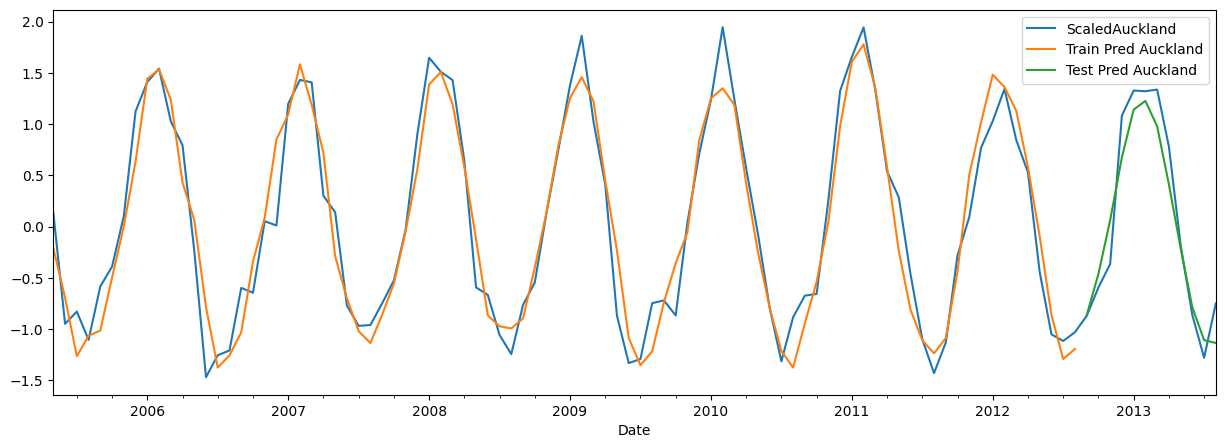

In [46]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

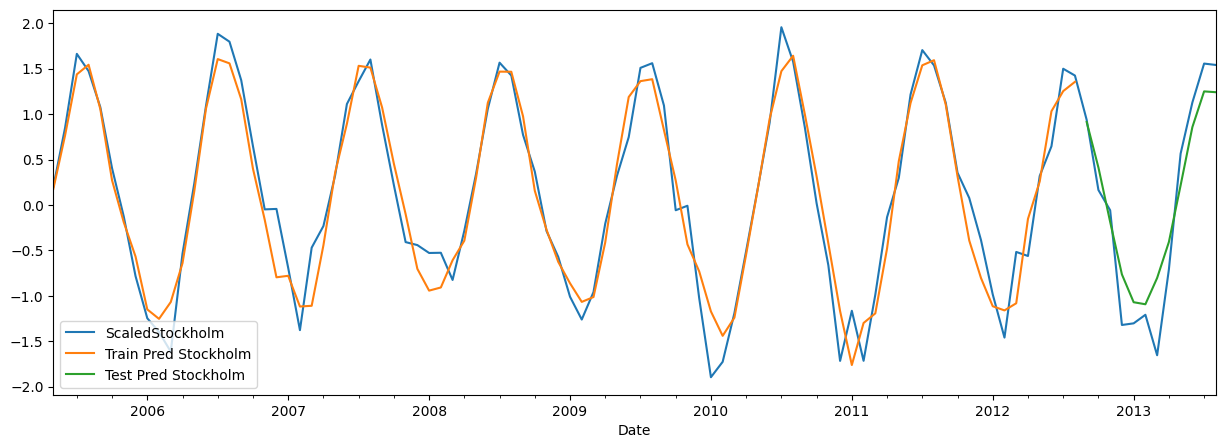

In [47]:
joined_part.loc[train_idx, 'Train Pred Stockholm'] = results.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast[:,1]

plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [53]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
y_pred = y_pred[lag_order:]
y_true = y_true[lag_order:]
print(f"Auckland Train R^2: {r2_score(y_true, y_pred)}")

y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']

print(f"Auckland Test R^2: {r2_score(y_true, y_pred)}")

Auckland Train R^2: 0.921070700106029
Auckland Test R^2: 0.9233643831340894


In [54]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
y_pred = y_pred[lag_order:]
y_true = y_true[lag_order:]
print(f"Stockholm Train R^2: {r2_score(y_true, y_pred)}")

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']

print(f"Stockholm Test R^2: {r2_score(y_true, y_pred)}")

Stockholm Train R^2: 0.9267030553588321
Stockholm Test R^2: 0.8930437688204877


ARIMA Baseline

In [55]:
from statsmodels.tsa.arima.model import ARIMA

In [68]:
for col in cols:
    model = ARIMA(train[col], order=(10, 0, 10))
    res = model.fit()
    fcast = res.get_forecast(Ntest)

    print(f"{col} Train R^2: {r2_score(joined_part.loc[train_idx, col], res.fittedvalues)}")
    print(f"{col} Test R^2: {r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean)}")

/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213765345953839
ScaledAuckland Test R^2: 0.9380788887280245


/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledStockholm Train R^2: 0.9207190969531667
ScaledStockholm Test R^2: 0.9483606834365295
